In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [29]:
# Load data
matches = pd.read_csv('../data/processed/matches_cleaned.csv')
deliveries = pd.read_csv('../data/processed/deliveries_cleaned.csv')

# Standardize column names for analysis
# We know the dataset uses 'matchId', so we rename it directly
matches.rename(columns={'matchId': 'match_id'}, inplace=True)
deliveries.rename(columns={'matchId': 'match_id'}, inplace=True)

# Rename scoring columns for clarity
# 'batsman_runs' is the specific run off the bat, 'extras' is separate
deliveries.rename(columns={'batsman_runs': 'runs_off_bat'}, inplace=True)

# Create a 'total_runs' feature (runs + extras)
deliveries['total_runs'] = deliveries['runs_off_bat'] + deliveries['extras']

print("Data loaded successfully.")
print(f"Matches: {matches.shape}")
print(f"Deliveries: {deliveries.shape}")

Data loaded successfully.
Matches: (1169, 28)
Deliveries: (278205, 21)


In [39]:
# Check for missing values after cleaning to ensure quality
print("Missing Values in Matches:\n", matches.isnull().sum())

# Peek at the data to verify column names (like 'match_id' and 'total_runs') are correct
print("\nSample Data:")
display(matches.head(3))
display(deliveries.head(3))

Missing Values in Matches:
 season                0
venue                 0
event                 0
winner_runs         638
umpire2               0
toss_winner           0
date                  0
neutralvenue       1092
umpire1               0
city                  0
reserve_umpire       24
winner                0
eliminator         1154
date1              1167
method             1150
team1                 0
toss_decision         0
gender                0
team2                 0
balls_per_over        0
winner_wickets      554
tv_umpire             4
player_of_match       8
match_referee         0
outcome            1146
date2              1167
match_number         70
match_id              0
dtype: int64

Sample Data:


,season,venue,event,winner_runs,umpire2,toss_winner,date,neutralvenue,umpire1,city,reserve_umpire,winner,eliminator,date1,method,team1,toss_decision,gender,team2,balls_per_over,winner_wickets,tv_umpire,player_of_match,match_referee,outcome,date2,match_number,match_id
0,2007/08,M. Chinnaswamy Stadium,Indian Premier League,140.0,RE Koertzen,Royal Challengers Bengaluru,2008-04-18,NaN,Asad Rauf,Bangalore,VN Kulkarni,Kolkata Knight Riders,NaN,NaN,NaN,Royal Challengers Bengaluru,field,male,Kolkata Knight Riders,6,NaN,AM Saheba,BB McCullum,J Srinath,NaN,NaN,1.0,335982
1,2007/08,"Punjab Cricket Association Stadium, Mohali",Indian Premier League,33.0,SL Shastri,Chennai Super Kings,2008-04-19,NaN,MR Benson,Chandigarh,MSS Ranawat,Chennai Super Kings,NaN,NaN,NaN,Punjab Kings,bat,male,Chennai Super Kings,6,NaN,RB Tiffin,MEK Hussey,S Venkataraghavan,NaN,NaN,2.0,335983
2,2007/08,Feroz Shah Kotla,Indian Premier League,NaN,GA Pratapkumar,Rajasthan Royals,2008-04-19,NaN,Aleem Dar,Delhi,NaN,Delhi Capitals,NaN,NaN,NaN,Delhi Capitals,bat,male,Rajasthan Royals,6,9.0,IL Howell,MF Maharoof,GR Viswanath,NaN,NaN,3.0,335984


,match_id,inning,over_ball,over,ball,batting_team,bowling_team,batter,non_striker,bowler,runs_off_bat,extras,isWide,isNoBall,Byes,LegByes,Penalty,dismissal_kind,player_dismissed,date,total_runs
0,335982,1,0.1,0,1,Kolkata Knight Riders,Royal Challengers Bengaluru,SC Ganguly,BB McCullum,P Kumar,0,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2008-04-18,1
1,335982,1,0.2,0,2,Kolkata Knight Riders,Royal Challengers Bengaluru,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,0
2,335982,1,0.3,0,3,Kolkata Knight Riders,Royal Challengers Bengaluru,BB McCullum,SC Ganguly,P Kumar,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,1


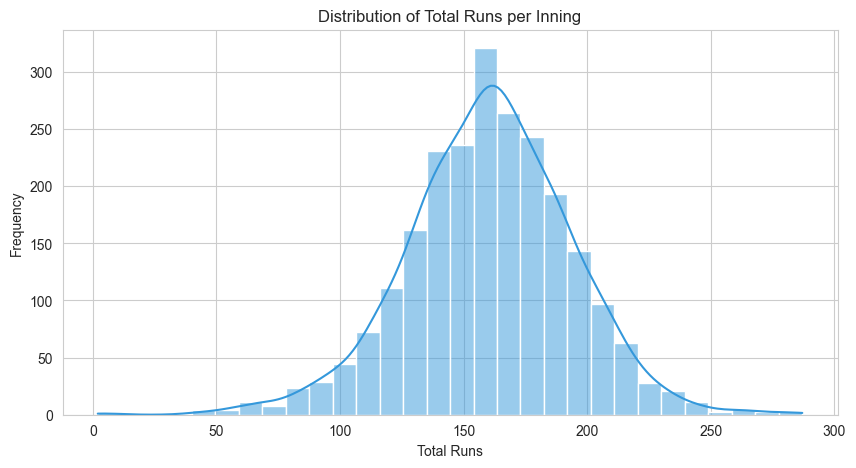

Average Innings Score: 160.30


In [45]:
# Aggregate runs per match and inning
inning_scores = deliveries.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()

# Filter for first 2 innings only (ignore super overs for distribution)
inning_scores = inning_scores[inning_scores['inning'] <= 2]

# Plotting
plt.figure(figsize=(10, 5))
sns.histplot(inning_scores['total_runs'], kde=True, bins=30, color='#3498db')
plt.title('Distribution of Total Runs per Inning')
plt.xlabel('Total Runs')
plt.ylabel('Frequency')
plt.show()

print(f"Average Innings Score: {inning_scores['total_runs'].mean():.2f}")

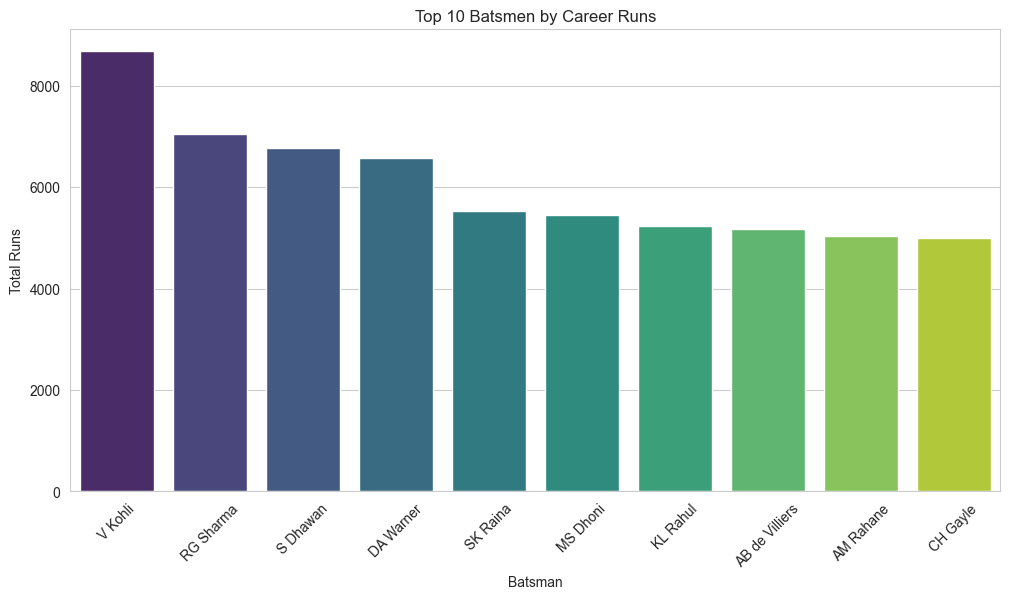

In [31]:
# Calculate total runs for each batter
# Note: Dataset uses 'batsman' column for player names
top_batters = deliveries.groupby('batsman')['runs_off_bat'].sum().sort_values(ascending=False).head(10)

# Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_batters.index, y=top_batters.values, hue=top_batters.index, legend=False, palette='viridis')
plt.title('Top 10 Batsmen by Career Runs')
plt.xlabel('Batsman')
plt.ylabel('Total Runs')
plt.xticks(rotation=45)
plt.show()

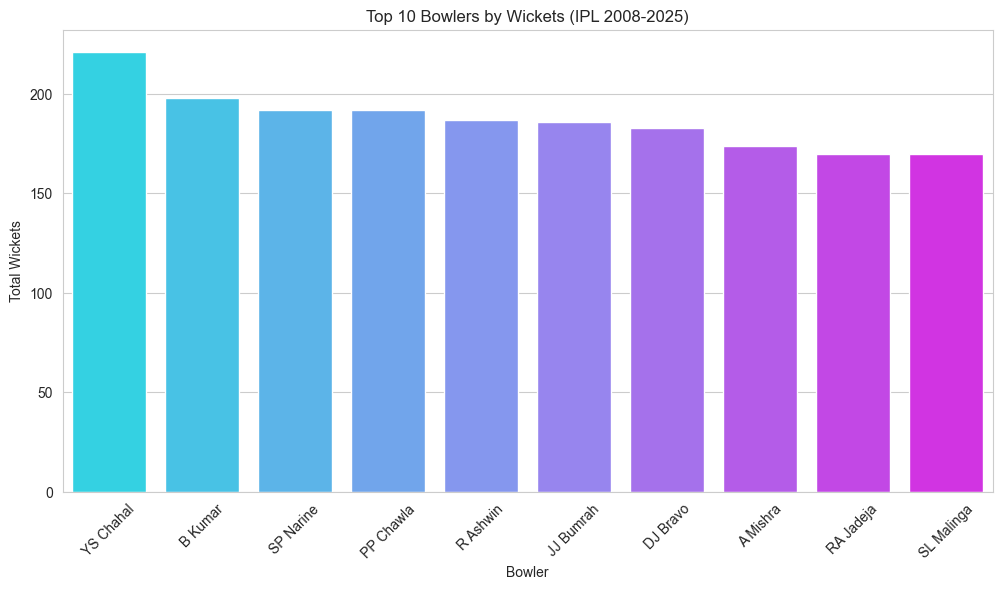

In [48]:
# Filter for valid dismissals (excluding run-outs which are team efforts)
valid_dismissals = ['caught', 'bowled', 'lbw', 'stumped', 'caught and bowled', 'hit wicket']
wickets = deliveries[deliveries['dismissal_kind'].isin(valid_dismissals)]

# Count wickets per bowler
# Note: Dataset uses 'bowler' column
top_bowlers = wickets['bowler'].value_counts().head(10)

# Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_bowlers.index, y=top_bowlers.values, hue=top_bowlers.index, legend=False, palette='cool')
plt.title('Top 10 Bowlers by Wickets (IPL 2008-2025)')
plt.xlabel('Bowler')
plt.ylabel('Total Wickets')
plt.xticks(rotation=45)
plt.show()

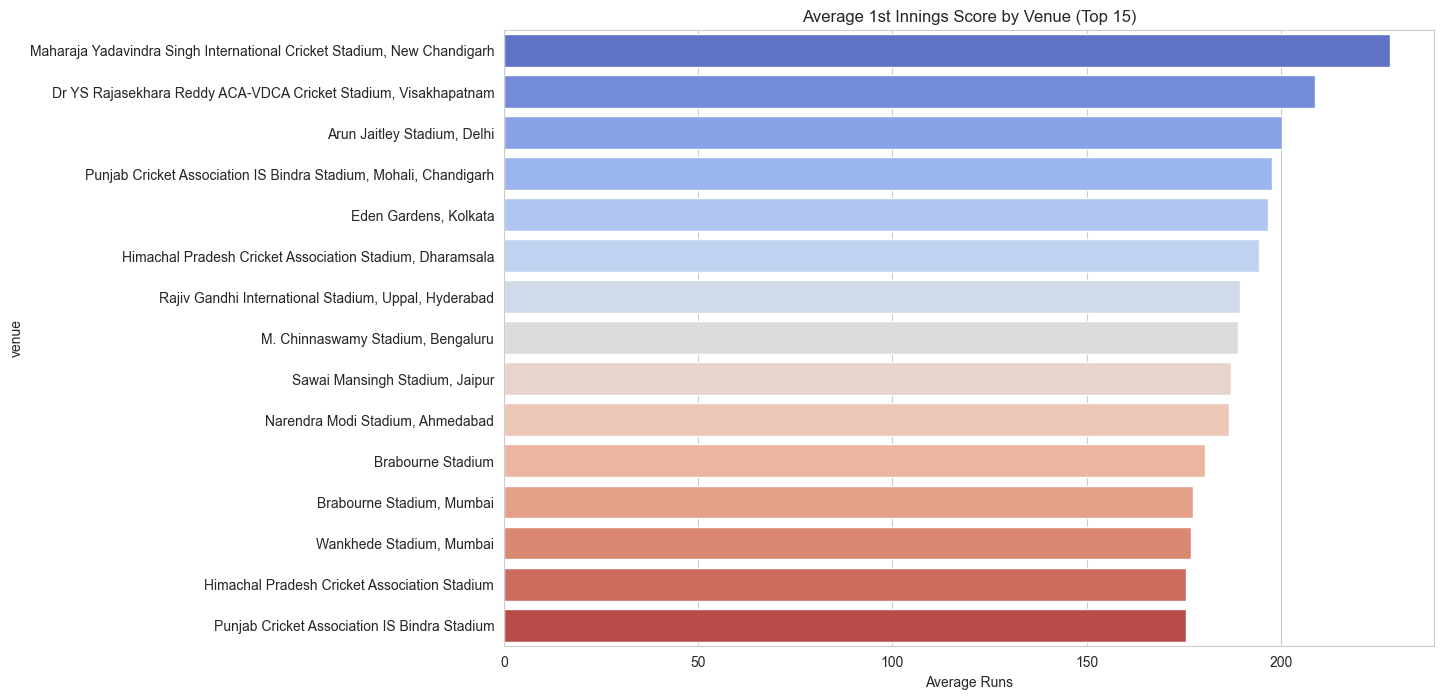

In [32]:
# Analyze 1st innings scores to judge pitch conditions
first_innings = inning_scores[inning_scores['inning'] == 1]

# Merge with matches to get venue names
venue_runs = pd.merge(first_innings, matches[['match_id', 'venue']], on='match_id')

# Get top 15 venues by average score
venue_avg = venue_runs.groupby('venue')['total_runs'].mean().sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(y=venue_avg.index, x=venue_avg.values, hue=venue_avg.index, legend=False, palette='coolwarm')
plt.title('Average 1st Innings Score by Venue (Top 15)')
plt.xlabel('Average Runs')
plt.show()

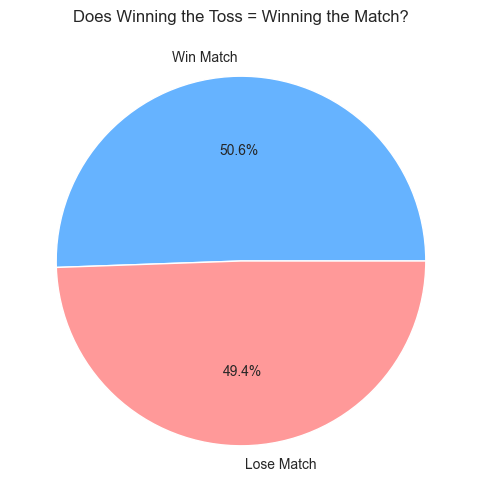

In [33]:
# Analyze the impact of winning the toss
# Check if the toss winner also won the match
matches['toss_match_winner'] = matches['toss_winner'] == matches['winner']
toss_impact = matches['toss_match_winner'].value_counts(normalize=True)

# Pie Chart Visualization
plt.figure(figsize=(6, 6))
plt.pie(toss_impact, labels=['Win Match', 'Lose Match'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title('Does Winning the Toss = Winning the Match?')
plt.show()

In [47]:
print("EDA Summary & Key Findings:")
print(f"1. Total Matches: {matches['match_id'].nunique()}")
print(f"2. Most Successful Batsman: {top_batters.index[0]} ({top_batters.values[0]} runs)")
print(f"3. Most Successful Bowler: {top_bowlers.index[0]} ({top_bowlers.values[0]} wickets)")
print(f"4. Toss Win % Impact: {toss_impact[True]*100:.1f}% correlation with match win")

EDA Summary & Key Findings:
1. Total Matches: 1169
2. Most Successful Batsman: V Kohli (8671 runs)
3. Most Successful Bowler: YS Chahal (221 wickets)
4. Toss Win % Impact: 50.6% correlation with match win
